# Electric Vehicle Accident Regression Analysis with PySpark

In [13]:
# PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lit, when, to_timestamp, year, month, dayofmonth, hour, dayofweek,
    udf, count, sum, avg, min, max, expr
)
from pyspark.sql.types import IntegerType

# PySpark ML libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler
)
from pyspark.ml.regression import (
    LinearRegression, RandomForestRegressor, GBTRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator

# Hyperparameter optimization library
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set visualization styles
plt.style.use('ggplot')
sns.set_palette('Set2')

# Set random seed for reproducibility
import random
random.seed(42)

In [ ]:
# Initialize Spark Session with increased timeout and memory settings
spark = SparkSession.builder \
    .appName("EVAccidentRegression") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "120s") \
    .config("spark.python.worker.timeout", "300") \
    .config("spark.rpc.askTimeout", "300s") \
    .config("spark.task.maxFailures", "4") \
    .getOrCreate()

# Set log level to minimize verbose output
spark.sparkContext.setLogLevel("ERROR")

## 1. Loading and Initial Data Exploration

In [15]:
# Load the dataset
df = spark.read.option("header", True).csv("final_data")
df = df.withColumn("ZIP CODE", col("ZIP CODE").cast(IntegerType()))

df.printSchema()

df.show(5)

# Filter only electric vehicles
ev_df = df.filter(col("is_e_vehicle") == True)
print(f"Number of electric vehicle accidents: {ev_df.count()}")

# Create target variable for regression (total injury/death count)
ev_df = ev_df.withColumn(
    "INJURY_SEVERITY", 
    col("NUMBER OF PERSONS INJURED") + col("NUMBER OF PERSONS KILLED")*5
)

# Check target variable distribution
ev_df.select("INJURY_SEVERITY").summary().show()

# Calculate descriptive statistics
injury_stats = ev_df.agg(
    avg("INJURY_SEVERITY").alias("mean"),
    max("INJURY_SEVERITY").alias("max"),
    min("INJURY_SEVERITY").alias("min"),
    expr("percentile_approx(INJURY_SEVERITY, 0.5)").alias("median")
)
injury_stats.show()

root
 |-- CRASH DATE & TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: string (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: string (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 3: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 4: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 5: string (nullable = true)
 |-- VEHICLE TYPE 

Number of electric vehicle accidents: 18531


+-------+------------------+
|summary|   INJURY_SEVERITY|
+-------+------------------+
|  count|             18531|
|   mean|0.8757217635313799|
| stddev|0.6194712166933473|
|    min|               0.0|
|    25%|               1.0|
|    50%|               1.0|
|    75%|               1.0|
|    max|              10.0|
+-------+------------------+

+------------------+----+---+------+
|              mean| max|min|median|
+------------------+----+---+------+
|0.8757217635313799|10.0|0.0|   1.0|
+------------------+----+---+------+



In [16]:
# Data preprocessing - Create temporal features
ev_df = ev_df.withColumn("CRASH DATE & TIME", to_timestamp(col("CRASH DATE & TIME")))

# Extract temporal features
ev_df = ev_df.withColumn("Year", year(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("Month", month(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("Day", dayofmonth(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("Hour", hour(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("DayOfWeek", dayofweek(col("CRASH DATE & TIME")) - 1)

# Display examples of the new features
ev_df.select("CRASH DATE & TIME", "Year", "Month", "Day", "Hour", "DayOfWeek", "INJURY_SEVERITY").show(5)

+-------------------+----+-----+---+----+---------+---------------+
|  CRASH DATE & TIME|Year|Month|Day|Hour|DayOfWeek|INJURY_SEVERITY|
+-------------------+----+-----+---+----+---------+---------------+
|2017-04-21 18:02:00|2017|    4| 21|  18|        5|            1.0|
|2017-04-28 18:50:00|2017|    4| 28|  18|        5|            1.0|
|2017-05-05 14:20:00|2017|    5|  5|  14|        5|            1.0|
|2017-05-12 18:35:00|2017|    5| 12|  18|        5|            1.0|
|2017-06-11 03:05:00|2017|    6| 11|   3|        0|            1.0|
+-------------------+----+-----+---+----+---------+---------------+
only showing top 5 rows



## 2. Feature Selection and Engineering

In [17]:
# Select base features for modeling
features = [
    "Month", "Day", "Hour", "DayOfWeek", 
    "VEHICLE TYPE CODE 2", "ZIP CODE", "CONTRIBUTING FACTOR VEHICLE 1"
]

# Define target variable for regression
target_regression = "INJURY_SEVERITY"

# Remove rows with missing values in the selected features
df_clean = ev_df.dropna(subset=features + [target_regression])

print(f"Original dataset count: {ev_df.count()}")
print(f"Clean dataset count: {df_clean.count()}")

# Create additional time-based features
# Rush hour: 7-9 AM and 4-7 PM
df_clean = df_clean.withColumn(
    "IsRushHour", 
    when(
        ((col("Hour") >= 7) & (col("Hour") <= 9)) | 
        ((col("Hour") >= 16) & (col("Hour") <= 19)),
        1
    ).otherwise(0)
)

# Night time: 10 PM to 5 AM
df_clean = df_clean.withColumn(
    "IsNightTime", 
    when(
        (col("Hour") >= 22) | (col("Hour") <= 5),
        1
    ).otherwise(0)
)

# Weekend: Saturday (5) and Sunday (6)
df_clean = df_clean.withColumn(
    "IsWeekend", 
    when(
        col("DayOfWeek") >= 5,
        1
    ).otherwise(0)
)

features.extend(["IsRushHour", "IsWeekend", "IsNightTime"])

df_clean.select("IsRushHour", "IsWeekend", "IsNightTime").summary().show()

Original dataset count: 18531


Clean dataset count: 15226


+-------+------------------+------------------+-------------------+
|summary|        IsRushHour|         IsWeekend|        IsNightTime|
+-------+------------------+------------------+-------------------+
|  count|             15226|             15226|              15226|
|   mean|0.3958360698804676|0.2974517273085512|0.16511230789439119|
| stddev|0.4890455841447253|0.4571519692147792|0.37129407196818964|
|    min|                 0|                 0|                  0|
|    25%|                 0|                 0|                  0|
|    50%|                 0|                 0|                  0|
|    75%|                 1|                 1|                  0|
|    max|                 1|                 1|                  1|
+-------+------------------+------------------+-------------------+



## 3. Data Preparation for ML

In [18]:
# Identify categorical and numerical features
categorical_features = ["Month", "Hour", "DayOfWeek", "VEHICLE TYPE CODE 2", "CONTRIBUTING FACTOR VEHICLE 1"]
numerical_features = ["Day", "ZIP CODE", "IsRushHour", "IsWeekend", "IsNightTime"]

# Create stages for the pipeline
stages = []

# Process categorical features
for feature in categorical_features:
    # StringIndexer: Converts string column to indices
    indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_indexed", handleInvalid="keep")
    
    # OneHotEncoder: Creates binary vectors from categorical features
    encoder = OneHotEncoder(inputCols=[f"{feature}_indexed"], outputCols=[f"{feature}_encoded"], dropLast=True)
    
    stages += [indexer, encoder]

# Process numerical features - no transformation needed, they're already numeric
# Just create a list of feature names after all the transformations
encoded_categorical_features = [f"{feature}_encoded" for feature in categorical_features]
feature_names = numerical_features + encoded_categorical_features

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_names, outputCol="features", handleInvalid="skip")
stages += [assembler]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Create train-test split
train_val_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)
train_data, val_data = train_val_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training data count: {train_data.count()}")
print(f"Validation data count: {val_data.count()}")
print(f"Test data count: {test_data.count()}")

# Fit the pipeline on training data
pipeline_model = pipeline.fit(train_val_data)

# Transform the data
train_data_transformed = pipeline_model.transform(train_data)
val_data_transformed = pipeline_model.transform(val_data)
test_data_transformed = pipeline_model.transform(test_data)

# Initialize the evaluator for regression
evaluator_rmse = RegressionEvaluator(
    labelCol=target_regression,
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
    labelCol=target_regression,
    predictionCol="prediction",
    metricName="mae"
)

evaluator_r2 = RegressionEvaluator(
    labelCol=target_regression,
    predictionCol="prediction",
    metricName="r2"
)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=63234Kb max_used=63815Kb free=67837Kb
 bounds [0x00000001089e0000, 0x000000010c8a0000, 0x00000001109e0000]
 total_blobs=17587 nmethods=16612 adapters=886
 compilation: disabled (not enough contiguous free space left)


Training data count: 9830


Validation data count: 2381


Test data count: 3015


## 4. Hyperparameter Tuning with Optuna

In [19]:
# Define objective function for Linear Regression optimization
def objective_lr(trial):
    reg_param = trial.suggest_float('regParam', 0.01, 1.0, log=True)
    elastic_net_param = trial.suggest_float('elasticNetParam', 0.0, 1.0)
    max_iter = trial.suggest_int('maxIter', 10, 100)
    
    # Create model with suggested parameters
    lr = LinearRegression(
        featuresCol="features",
        labelCol=target_regression,
        regParam=reg_param,
        elasticNetParam=elastic_net_param,
        maxIter=max_iter
    )
    
    # Train and evaluate model - we want to minimize RMSE
    model = lr.fit(train_data_transformed)
    predictions = model.transform(val_data_transformed)
    rmse_score = evaluator_rmse.evaluate(predictions)
    
    return rmse_score

# Create a study for Linear Regression
lr_study = optuna.create_study(direction='minimize')
lr_study.optimize(objective_lr, n_trials=5)

print(f"\nBest trial for Linear Regression:")
print(f"Value (RMSE): {lr_study.best_value:.4f}")
print(f"Params:")
for key, value in lr_study.best_params.items():
    print(f"{key}: {value}")

# Create best Linear Regression model
best_lr = LinearRegression(
    featuresCol="features",
    labelCol=target_regression,
    regParam=lr_study.best_params['regParam'],
    elasticNetParam=lr_study.best_params['elasticNetParam'],
    maxIter=lr_study.best_params['maxIter']
)

[I 2025-04-13 21:59:12,721] A new study created in memory with name: no-name-2c99cb75-7368-4ea9-9ccc-4f8f0b3b8166
[I 2025-04-13 21:59:21,634] Trial 0 finished with value: 0.6122219638772833 and parameters: {'regParam': 0.01935118848675036, 'elasticNetParam': 0.41272526287663347, 'maxIter': 78}. Best is trial 0 with value: 0.6122219638772833.
[I 2025-04-13 21:59:27,050] Trial 1 finished with value: 0.6127445560535838 and parameters: {'regParam': 0.02891756630360548, 'elasticNetParam': 0.5383234126986403, 'maxIter': 81}. Best is trial 0 with value: 0.6122219638772833.
[I 2025-04-13 21:59:31,838] Trial 2 finished with value: 0.6130348193407732 and parameters: {'regParam': 0.04573256451549036, 'elasticNetParam': 0.42628941390410624, 'maxIter': 23}. Best is trial 0 with value: 0.6122219638772833.
[I 2025-04-13 21:59:37,006] Trial 3 finished with value: 0.6126122037401865 and parameters: {'regParam': 0.07032643459461935, 'elasticNetParam': 0.17619147110108757, 'maxIter': 66}. Best is trial 0


Best trial for Linear Regression:
Value (RMSE): 0.6122
Params:
regParam: 0.01935118848675036
elasticNetParam: 0.41272526287663347
maxIter: 78


In [20]:
# Define objective function for optimization
def objective_rf(trial):
    num_trees = trial.suggest_int('numTrees', 10, 100, step=10)
    max_depth = trial.suggest_int('maxDepth', 5, 20, step=5)
    min_instances_per_node = trial.suggest_int('minInstancesPerNode', 1, 10)
    
    # Create model with suggested parameters
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol=target_regression,
        numTrees=num_trees,
        maxDepth=max_depth,
        minInstancesPerNode=min_instances_per_node,
        seed=42
    )
    
    # Train and evaluate model
    model = rf.fit(train_data_transformed)
    predictions = model.transform(val_data_transformed)
    rmse_score = evaluator_rmse.evaluate(predictions)
    
    return rmse_score

# Create a study for Random Forest
rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(objective_rf, n_trials=5)

print(f"\nBest trial for Random Forest Regressor:")
print(f"Value (RMSE): {rf_study.best_value:.4f}")
print(f"Params:")
for key, value in rf_study.best_params.items():
    print(f"{key}: {value}")

# Create best Random Forest model
best_rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=target_regression,
    numTrees=rf_study.best_params['numTrees'],
    maxDepth=rf_study.best_params['maxDepth'],
    minInstancesPerNode=rf_study.best_params['minInstancesPerNode'],
    seed=42
)

[I 2025-04-13 21:59:41,857] A new study created in memory with name: no-name-67cc2b78-66f3-4609-85d0-c8d47cd39295
[I 2025-04-13 22:00:10,379] Trial 0 finished with value: 0.6145753876428275 and parameters: {'numTrees': 100, 'maxDepth': 15, 'minInstancesPerNode': 7}. Best is trial 0 with value: 0.6145753876428275.
[I 2025-04-13 22:00:20,789] Trial 1 finished with value: 0.6139717306805107 and parameters: {'numTrees': 20, 'maxDepth': 10, 'minInstancesPerNode': 6}. Best is trial 1 with value: 0.6139717306805107.
[I 2025-04-13 22:00:36,549] Trial 2 finished with value: 0.6154229793760012 and parameters: {'numTrees': 80, 'maxDepth': 15, 'minInstancesPerNode': 8}. Best is trial 1 with value: 0.6139717306805107.
[I 2025-04-13 22:00:47,502] Trial 3 finished with value: 0.620799856082749 and parameters: {'numTrees': 20, 'maxDepth': 20, 'minInstancesPerNode': 8}. Best is trial 1 with value: 0.6139717306805107.
[I 2025-04-13 22:00:55,892] Trial 4 finished with value: 0.6120037759100149 and parame


Best trial for Random Forest Regressor:
Value (RMSE): 0.6120
Params:
numTrees: 100
maxDepth: 5
minInstancesPerNode: 7


In [21]:
# Define objective function for GBT optimization
def objective_gbt(trial):
    max_iter = trial.suggest_int('maxIter', 10, 50, step=5)
    max_depth = trial.suggest_int('maxDepth', 3, 15, step=3)
    step_size = trial.suggest_float('stepSize', 0.01, 0.3, log=True)
    
    # Create model with suggested parameters
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol=target_regression,
        maxIter=max_iter,
        maxDepth=max_depth,
        stepSize=step_size,
        seed=42
    )
    
    # Train and evaluate model
    model = gbt.fit(train_data_transformed)
    predictions = model.transform(val_data_transformed)
    rmse_score = evaluator_rmse.evaluate(predictions)
    
    return rmse_score

# Create a study for GBT
gbt_study = optuna.create_study(direction='minimize')
gbt_study.optimize(objective_gbt, n_trials=5)

print(f"\nBest trial for Gradient Boosting Tree Regressor:")
print(f"Value (RMSE): {gbt_study.best_value:.4f}")
print(f"Params:")
for key, value in gbt_study.best_params.items():
    print(f"{key}: {value}")

# Create best GBT model
best_gbt = GBTRegressor(
    featuresCol="features",
    labelCol=target_regression,
    maxIter=gbt_study.best_params['maxIter'],
    maxDepth=gbt_study.best_params['maxDepth'],
    stepSize=gbt_study.best_params['stepSize'],
    seed=42
)

[I 2025-04-13 22:00:55,906] A new study created in memory with name: no-name-4723cd33-af95-4597-b209-bba11806f799
[I 2025-04-13 22:01:21,735] Trial 0 finished with value: 0.7190802246094963 and parameters: {'maxIter': 30, 'maxDepth': 12, 'stepSize': 0.058818000422790034}. Best is trial 0 with value: 0.7190802246094963.
[I 2025-04-13 22:01:40,698] Trial 1 finished with value: 0.728422795389012 and parameters: {'maxIter': 20, 'maxDepth': 12, 'stepSize': 0.08713319815013945}. Best is trial 0 with value: 0.7190802246094963.
[I 2025-04-13 22:01:50,136] Trial 2 finished with value: 0.6129095525465982 and parameters: {'maxIter': 20, 'maxDepth': 3, 'stepSize': 0.010164475913704703}. Best is trial 2 with value: 0.6129095525465982.
[I 2025-04-13 22:02:04,446] Trial 3 finished with value: 0.6495549446266721 and parameters: {'maxIter': 20, 'maxDepth': 9, 'stepSize': 0.020244200166292494}. Best is trial 2 with value: 0.6129095525465982.
[I 2025-04-13 22:02:14,494] Trial 4 finished with value: 0.625


Best trial for Gradient Boosting Tree Regressor:
Value (RMSE): 0.6129
Params:
maxIter: 20
maxDepth: 3
stepSize: 0.010164475913704703


## 5. Model Training and Evaluation


Training Linear Regression...


RMSE: 0.6053


MAE: 0.4001


R²: 0.0051


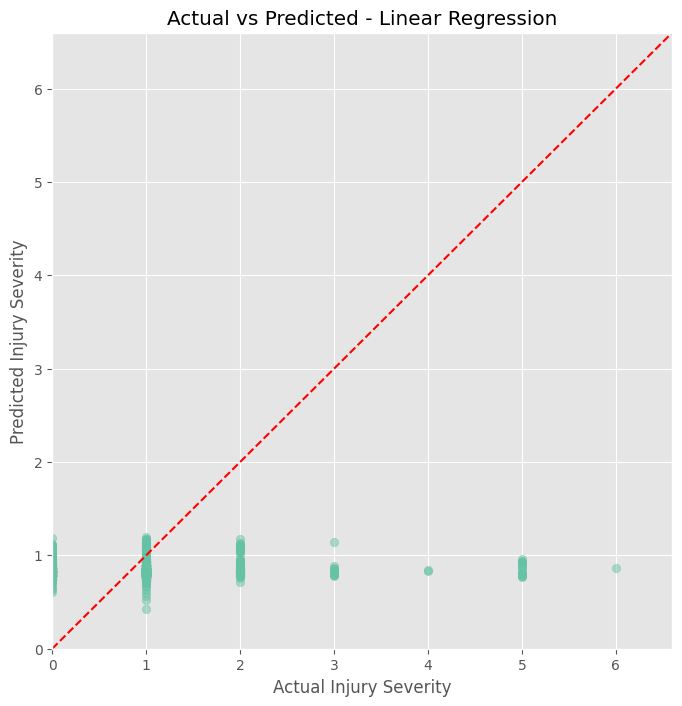

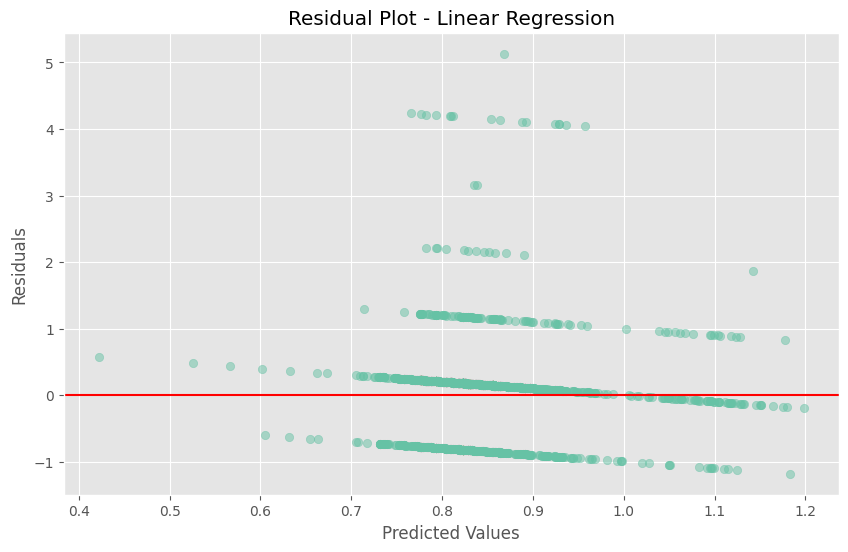


Training Random Forest Regressor...


RMSE: 0.6055


MAE: 0.4000


R²: 0.0046


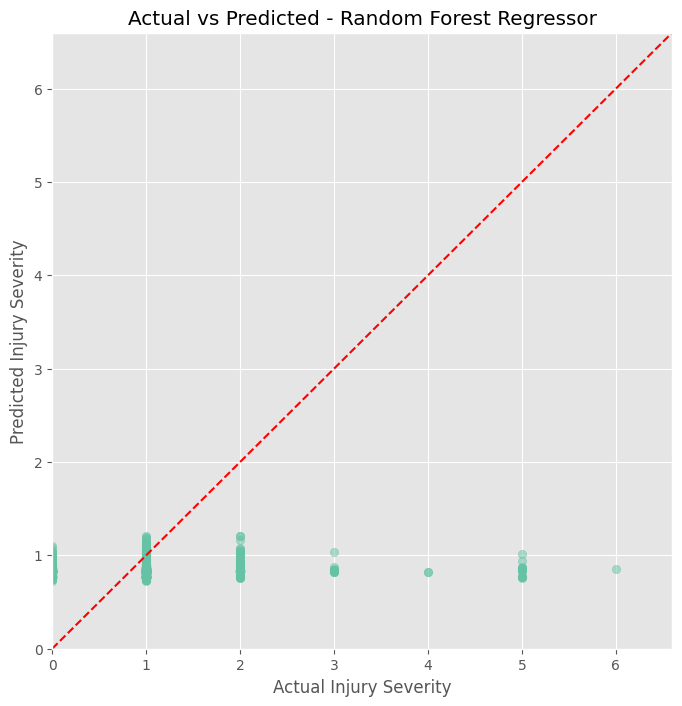

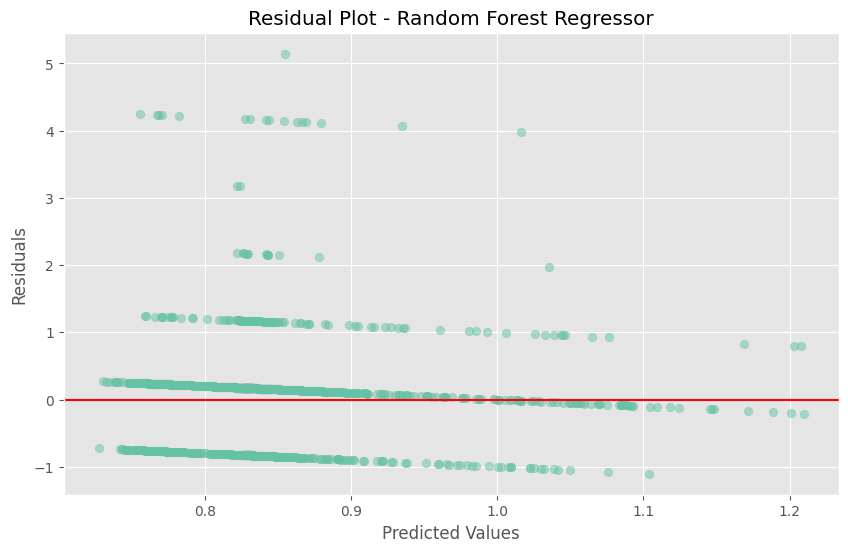


Training Gradient Boosting Regressor...


RMSE: 0.6062


MAE: 0.4022


R²: 0.0020


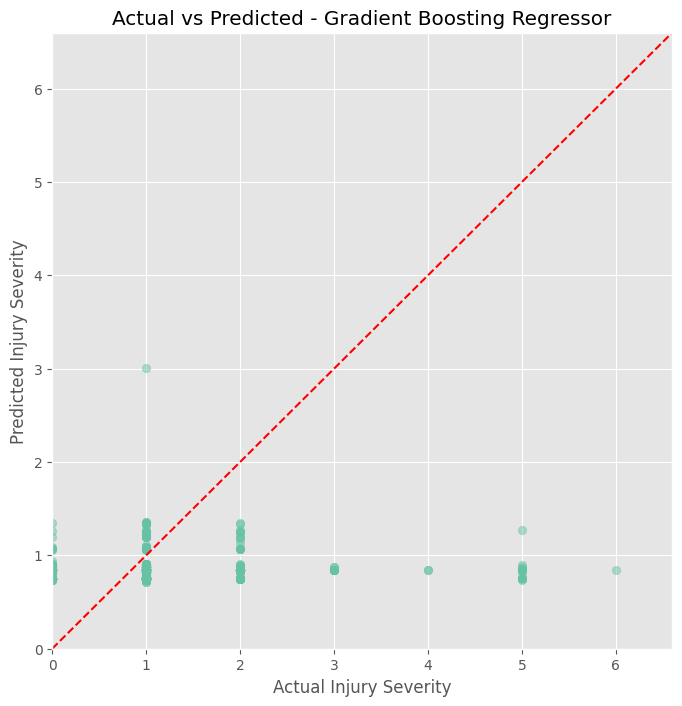

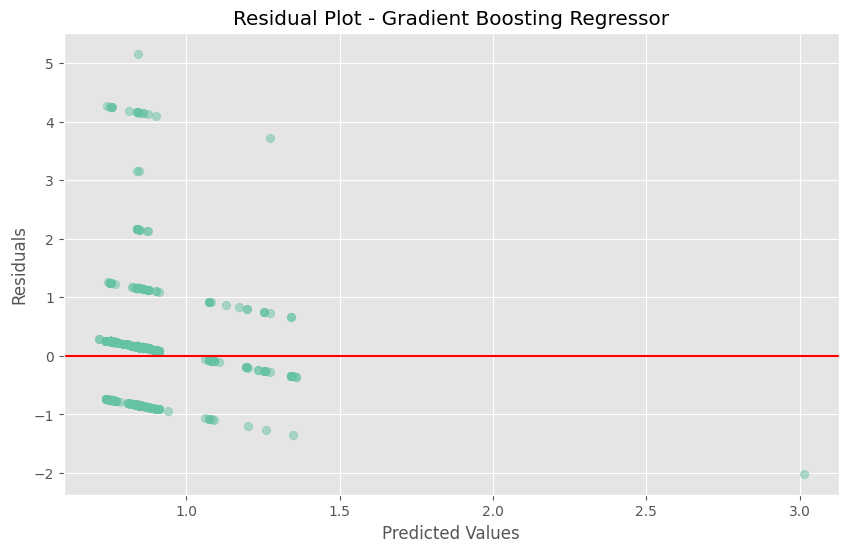

In [22]:
# Initialize models with optimized parameters
models = {
    "Linear Regression": best_lr,
    "Random Forest Regressor": best_rf,
    "Gradient Boosting Regressor": best_gbt
}

# Define evaluation metrics
evaluators = {
    "RMSE": evaluator_rmse,
    "MAE": evaluator_mae,
    "R²": evaluator_r2
}

# Train models and evaluate
results = {}
fitted_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model_fitted = model.fit(train_data_transformed)
    predictions = model_fitted.transform(test_data_transformed)
    
    fitted_models[model_name] = model_fitted
    
    # Calculate metrics
    model_results = {}
    for metric_name, evaluator in evaluators.items():
        score = evaluator.evaluate(predictions)
        model_results[metric_name] = score
        print(f"{metric_name}: {score:.4f}")
    
    results[model_name] = model_results
    
    # Convert to pandas DataFrame for examining predictions
    pred_df = predictions.select(target_regression, "prediction").toPandas()
    
    # Plot actual vs. predicted
    plt.figure(figsize=(8, 8))
    # Fix the max function error by using numpy's maximum
    max_val = np.maximum(pred_df[target_regression].max(), pred_df["prediction"].max()) * 1.1
    plt.scatter(pred_df[target_regression], pred_df["prediction"], alpha=0.5)
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlim([0, max_val])
    plt.ylim([0, max_val])
    plt.xlabel('Actual Injury Severity')
    plt.ylabel('Predicted Injury Severity')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.grid(True)
    plt.show()
    
    # Calculate and plot residuals
    pred_df['residuals'] = pred_df[target_regression] - pred_df["prediction"]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(pred_df["prediction"], pred_df['residuals'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.grid(True)
    plt.show()